In [ ]:
# Initial combined model

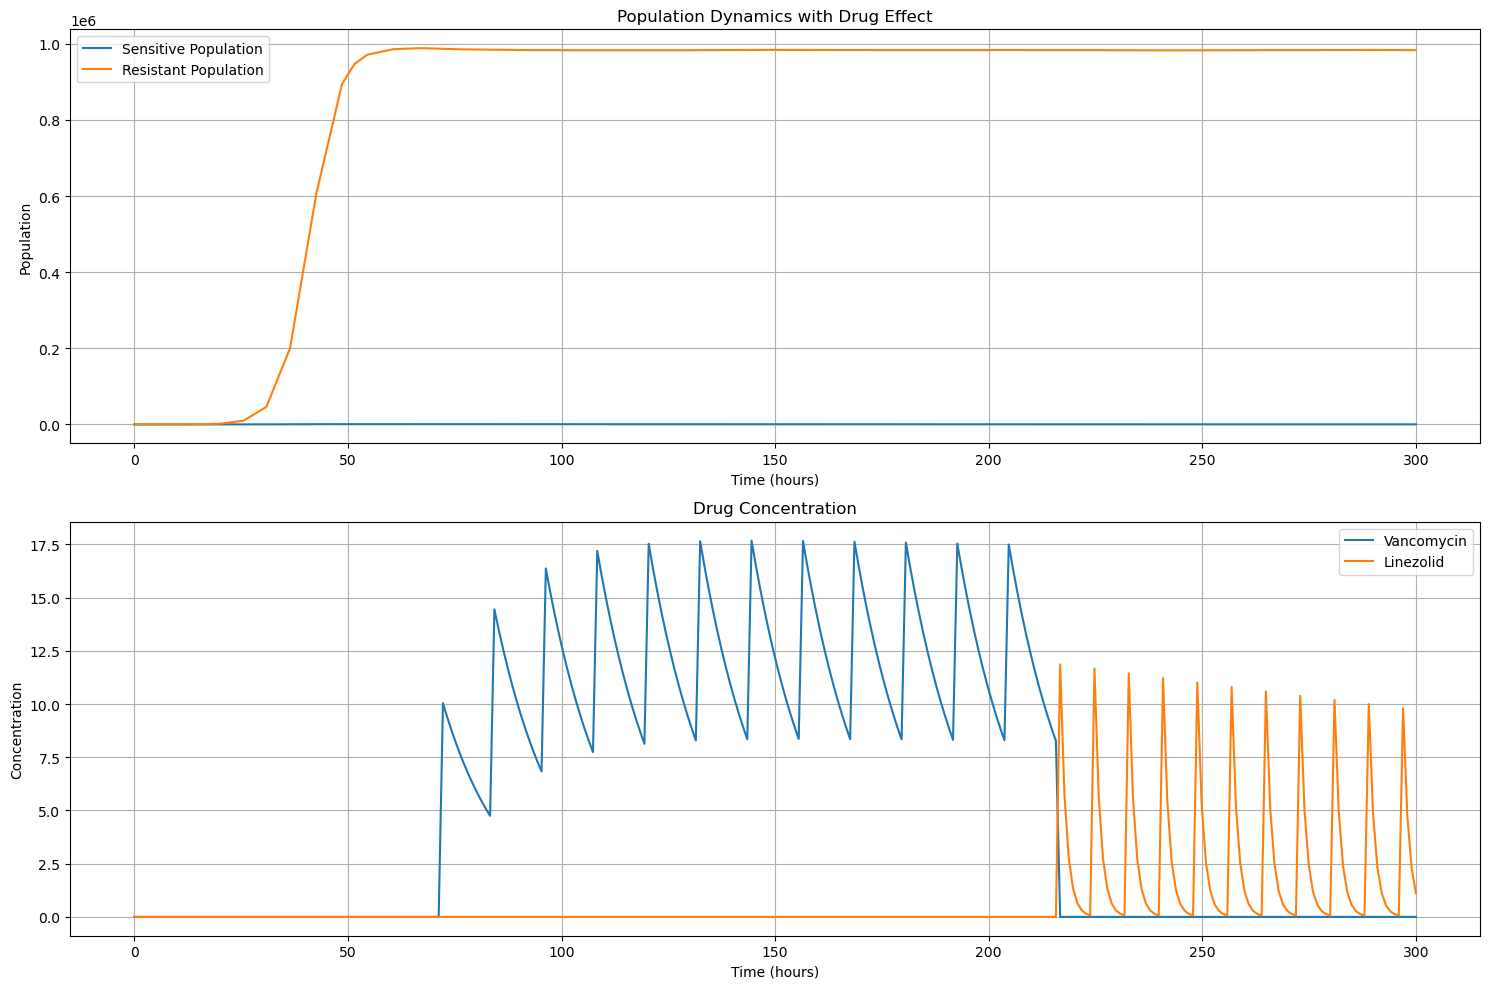

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

def Ke_Vancomycin(sCr, Age, weight, V=49):
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(CrCL, V):
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    conc = np.zeros_like(t)
    if dosing_times is None:
        # If no specific dosing times, create regular dosing schedule
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            # Calculate contribution from each dose
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def simulate_drug_dynamics(
    initial_sensitive=2, 
    initial_resistant=5, 
    total_simulation_time=300,
    no_drug_period=72,
    vancomycin_duration=6*24,
    linezolid_duration=8*24,
):
    # Patient Specific Parameters
    sCr = 1.3
    Age = 60
    weight = 70
    V_vancomycin = 49
    V_linezolid = 40

    # Calculate Elimination Rates
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight)
    CrCL = (140 - Age)*weight / (72 * sCr)
    Ke_linez = Ke_Linezolid(CrCL, V_linezolid)

    # Time Array
    time = np.linspace(0, total_simulation_time, total_simulation_time)

    # Vancomycin Dosing
    D_vancomycin = 500  # mg
    tau_vancomycin = 12  # hours
    vanco_start = no_drug_period
    vanco_end = vanco_start + vancomycin_duration

    # Linezolid Dosing
    D_linezolid = 800  # mg
    tau_linezolid = 8  # hours
    linez_start = vanco_end
    linez_end = linez_start + linezolid_duration

    # Create specific dosing times for Linezolid
    linezolid_dosing_times = np.arange(linez_start, linez_end, tau_linezolid)

    # Calculate Drug Concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin, 
        vanco_start, vanco_end
    )
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid, 
        linez_start, linez_end, linezolid_dosing_times
    )

    # Combined concentration both vancomycin and linezolid
    conc_combined = conc_vancomycin + conc_linezolid

    # Population Dynamics Parameters
    rho_sensitive = 0.15 #0.5
    rho_resistant = 0.3 #0.4
    k = 10e5
    EC_50 = 0.03
    max_drug_effect = 0.8
    #Rho values are growth rates and deltas are death rates
    delta_sensitive = 0.006
    delta_resistant = 0.003

    def population_ode(t, r):
        S, R = r
        conc_t = np.interp(t, time, conc_combined)
        
        drug_inhibition = max_drug_effect * (conc_t / (conc_t + EC_50))
        
        dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - drug_inhibition) - delta_sensitive * S
        dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - 0.5 * drug_inhibition) - delta_resistant * R
        
        return [dSdt, dRdt]

    solution = solve_ivp(
        population_ode, 
        [0, total_simulation_time], 
        [initial_sensitive, initial_resistant],
        dense_output=True
    )

    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(solution.t, solution.y[0], label='Sensitive Population')
    plt.plot(solution.t, solution.y[1], label='Resistant Population')
    plt.title('Population Dynamics with Drug Effect')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(time, conc_vancomycin, label='Vancomycin')
    plt.plot(time, conc_linezolid, label='Linezolid')
    plt.title('Drug Concentration')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    #plt.show()

    return solution, time, conc_combined

# Run the simulation
solution, time, conc_combined = simulate_drug_dynamics()

In [14]:

import plotly
print(plotly.__version__)


5.24.1


In [9]:
import ipywidgets as widgets
print(widgets.__version__)

7.8.1


# Improvements made to initial model


Key points in the solution:
Initial conditions:
Sensitive bacteria: 2.00
Resistant bacteria: 5.00

At the start of vancomycin treatment (t=48h):
Sensitive bacteria: 84911.80
Resistant bacteria: 782924.40

At the end of vancomycin treatment (t=120h):
Sensitive bacteria: 12252.56
Resistant bacteria: 955610.75

At the end of linezolid treatment (t=216h):
Sensitive bacteria: 821.63
Resistant bacteria: 975671.93

Final values:
Sensitive bacteria: 87.91
Resistant bacteria: 989464.73


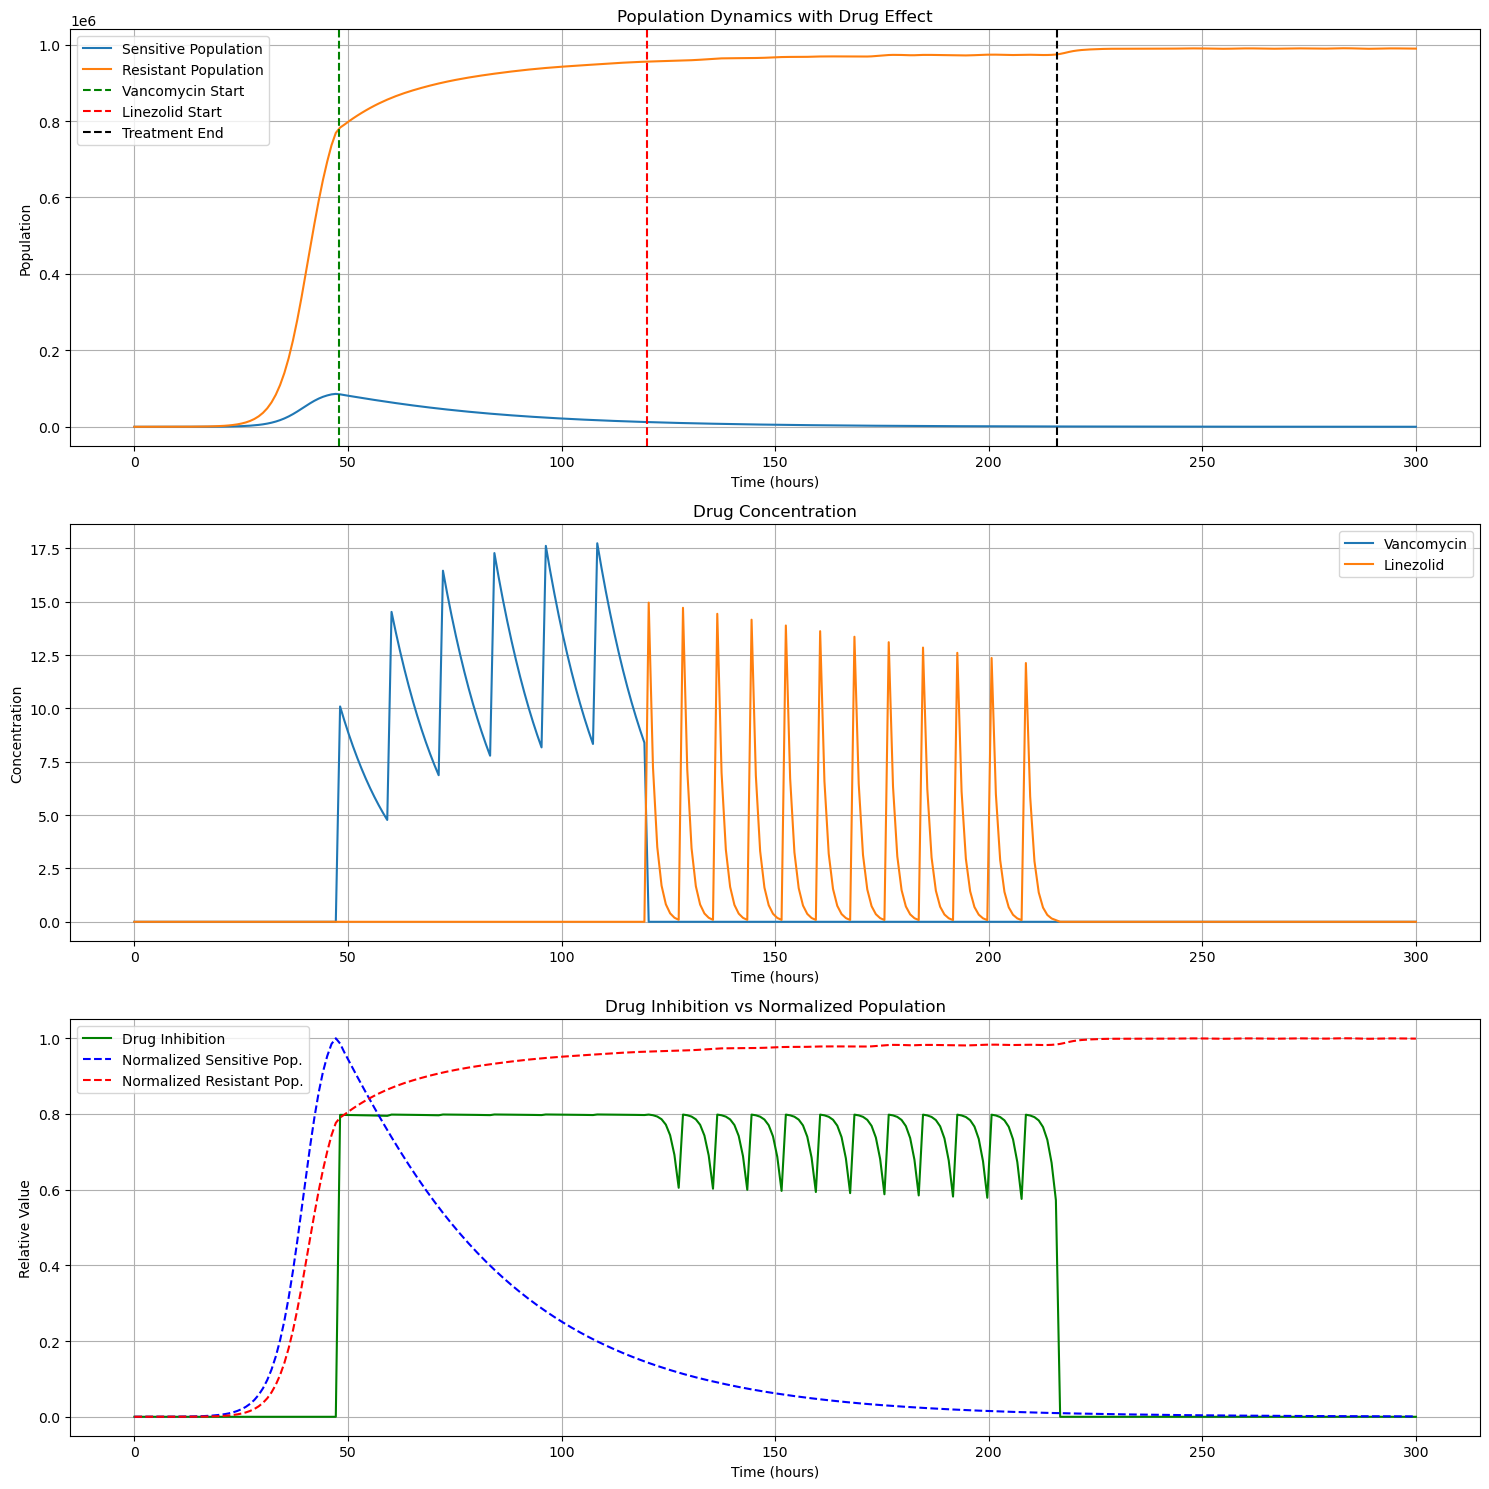

In [27]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

def Ke_Vancomycin(sCr, Age, weight, V=49):
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(CrCL, V):
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    conc = np.zeros_like(t)
    if dosing_times is None:
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def simulate_drug_dynamics(
    initial_sensitive=2, 
    initial_resistant=5, 
    no_drug_period=48,        # Reduced from 72
    vancomycin_duration=72,   # Reduced from 144
    linezolid_duration=96,    # Reduced from 192
    total_simulation_time=300
):
    # First, calculate all timing to ensure it fits
    vanco_start = no_drug_period
    vanco_end = vanco_start + vancomycin_duration
    linez_start = vanco_end
    linez_end = linez_start + linezolid_duration
    
    # Verify timing fits within simulation
    if linez_end > total_simulation_time:
        raise ValueError(f"Total treatment time ({linez_end}h) exceeds simulation time ({total_simulation_time}h)")

    # Patient Specific Parameters
    sCr = 1.3
    Age = 60
    weight = 70
    V_vancomycin = 49
    V_linezolid = 40

    # Calculate Elimination Rates
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight)
    CrCL = (140 - Age)*weight / (72 * sCr)
    Ke_linez = Ke_Linezolid(CrCL, V_linezolid)

    # Time Array
    time = np.linspace(0, total_simulation_time, total_simulation_time)

    # Vancomycin Dosing
    D_vancomycin = 500  # mg
    tau_vancomycin = 12  # hours

    # Linezolid Dosing
    D_linezolid = 800  # mg
    tau_linezolid = 8  # hours

    # Create specific dosing times for Linezolid
    #linezolid_dosing_times = np.arange(linez_start, linez_end, tau_linezolid)

    # Calculate Drug Concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin, 
        vanco_start, vanco_end
    )
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid, 
        linez_start, linez_end
    )

    # Combined concentration both vancomycin and linezolid
    conc_combined = conc_vancomycin + conc_linezolid

    # Population Dynamics Parameters
    rho_sensitive = 0.3 #increase growth rate of sensitive. making the two rates equal
    rho_resistant = 0.3
    k = 10e5
    EC_50 = 0.03
    max_drug_effect = 0.8
    delta_sensitive = 0.03 #increase death rate sensitive bacteria
    delta_resistant = 0.003

    def population_ode(t, r):
        S, R = r
        conc_t = np.interp(t, time, conc_combined)
        
        drug_inhibition = max_drug_effect * (conc_t / (conc_t + EC_50))
        
        dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - drug_inhibition) - delta_sensitive * S
        dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - 0.8 * drug_inhibition) - delta_resistant * R
        
        return [dSdt, dRdt]

    solution = solve_ivp(
        population_ode, 
        [0, total_simulation_time], 
        [initial_sensitive, initial_resistant],
        dense_output=True,
        t_eval=time
    )

    # Calculate drug inhibition over time
    drug_inhibition = max_drug_effect * (conc_combined / (conc_combined + EC_50))

    # Print key points in the solution
    print("\nKey points in the solution:")
    print(f"Initial conditions:")
    print(f"Sensitive bacteria: {solution.y[0][0]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][0]:.2f}")
    
    print(f"\nAt the start of vancomycin treatment (t={vanco_start}h):")
    idx_vanco = np.where(time >= vanco_start)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_vanco]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_vanco]:.2f}")
    
    print(f"\nAt the end of vancomycin treatment (t={vanco_end}h):")
    idx_vanco_end = np.where(time >= vanco_end)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_vanco_end]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_vanco_end]:.2f}")
    
    print(f"\nAt the end of linezolid treatment (t={linez_end}h):")
    idx_linez_end = np.where(time >= linez_end)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_linez_end]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_linez_end]:.2f}")
    
    print(f"\nFinal values:")
    print(f"Sensitive bacteria: {solution.y[0][-1]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][-1]:.2f}")

    plt.figure(figsize=(15, 15))
    
    # Population dynamics plot
    plt.subplot(3, 1, 1)
    plt.plot(time, solution.y[0], label='Sensitive Population')
    plt.plot(time, solution.y[1], label='Resistant Population')
    plt.axvline(x=vanco_start, color='g', linestyle='--', label='Vancomycin Start')
    plt.axvline(x=vanco_end, color='r', linestyle='--', label='Linezolid Start')
    plt.axvline(x=linez_end, color='k', linestyle='--', label='Treatment End')
    plt.title('Population Dynamics with Drug Effect')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)

    # Drug concentration plot
    plt.subplot(3, 1, 2)
    plt.plot(time, conc_vancomycin, label='Vancomycin')
    plt.plot(time, conc_linezolid, label='Linezolid')
    plt.title('Drug Concentration')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)

    # Drug inhibition plot
    plt.subplot(3, 1, 3)
    plt.plot(time, drug_inhibition, 'g-', label='Drug Inhibition')
    plt.plot(time, solution.y[0] / np.max(solution.y[0]), 'b--', label='Normalized Sensitive Pop.')
    plt.plot(time, solution.y[1] / np.max(solution.y[1]), 'r--', label='Normalized Resistant Pop.')
    plt.title('Drug Inhibition vs Normalized Population')
    plt.xlabel('Time (hours)')
    plt.ylabel('Relative Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    
    return solution, time, conc_combined, drug_inhibition

# Run the simulation
solution, time, conc_combined, drug_inhibition = simulate_drug_dynamics()

## Summary Points  
Added calculation of drug_inhibition using the combined drug concentration
The new subplot that shows:

Drug inhibition over time (green line)
Normalized sensitive bacterial population (blue dashed line)
Normalized resistant bacterial population (red dashed line)


Normalized the bacterial populations to their maximum values to better visualize the relationship with drug inhibition
Updated the figure size to accommodate the new plot

The plot helps visualize how the drug inhibition affects both bacterial populations over time. In particular:

- The resistant population is less affected by the drug inhibition (as designed in the model)

- The relationship between drug concentration and population decline

- The temporal relationship between peak drug inhibition and population changes


Other changes from initial model include:  


1. Reduced the duration of treatment phases:
   - No drug period: 48h (was 72h)
   - Vancomycin duration: 72h (was 144h)
   - Linezolid duration: 96h (was 192h)
2. Added error checking to ensure total treatment time fits within simulation time
3. Reorganized timing calculations to be more explicit
4. Updated variable names for consistency



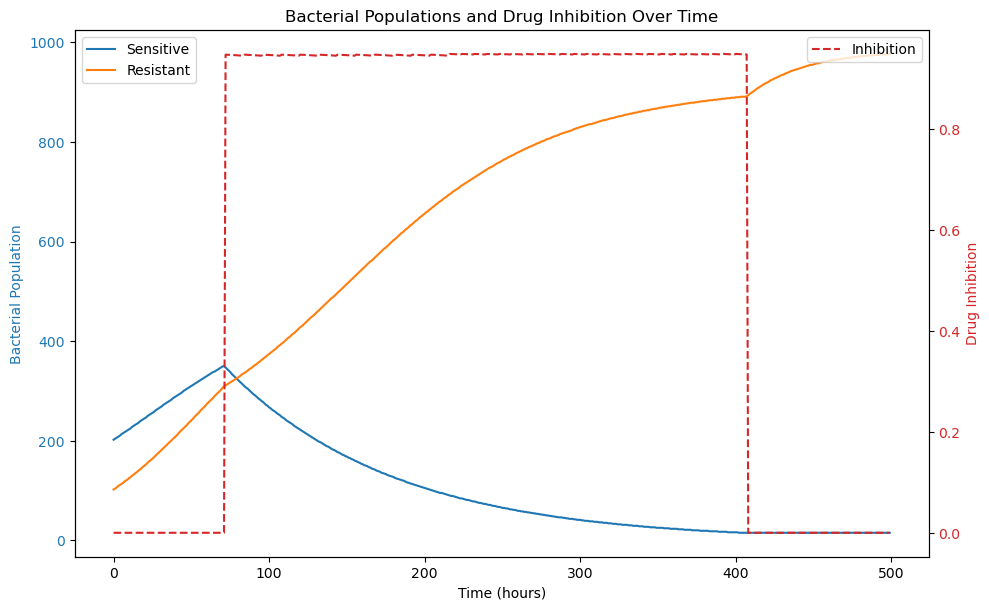

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt

# def generate_data():
#     rho_sensitive = 0.15 #0.3
#     rho_resistant = 0.3 #0.15
#     k = 1000
#     EC_50 = 0.03
#     max_drug_effect = 0.95
#     delta_sensitive = 0.001
#     delta_resistant = 0.0005
    
#     data = []
#     S = 200
#     R = 100
#     dt = 0.1
    
#     for t in range(500):
#         drugConc = 0
        
#         if 72 <= t < 216:
#             phase = (t - 72) % 12
#             drugConc = 10 * np.exp(-0.05 * phase)
#         elif 216 <= t < 408:
#             phase = (t - 216) % 8
#             drugConc = 20 * np.exp(-0.08 * phase)
        
#         drug_inhibition = max_drug_effect * (drugConc / (drugConc + EC_50))
        
#         dSdt = S * (
#             rho_sensitive * (1 - (S + R) / k) * (1 - drug_inhibition) - 
#             delta_sensitive - (drug_inhibition * 0.1)
#         )
        
#         dRdt = R * (
#             rho_resistant * (1 - (S + R) / k) * (1 - 0.2 * drug_inhibition) - 
#             delta_resistant - (drug_inhibition * 0.02)
#         )
        
#         S = max(0, S + dSdt * dt)
#         R = max(0, R + dRdt * dt)
        
#         if t % 1 == 0:
#             data.append({
#                 'time': t,
#                 'sensitive': round(S),
#                 'resistant': round(R),
#                 'inhibition': drug_inhibition,
#                 'total': round(S + R)
#             })
    
#     return data

# def plot_bacterial_populations(data):
#     times = [entry['time'] for entry in data]
#     sensitive = [entry['sensitive'] for entry in data]
#     resistant = [entry['resistant'] for entry in data]
#     inhibition = [entry['inhibition'] for entry in data]
    
#     fig, ax1 = plt.subplots(figsize=(10, 6))
    
#     ax1.set_xlabel('Time (hours)')
#     ax1.set_ylabel('Bacterial Population', color='tab:blue')
#     ax1.plot(times, sensitive, label='Sensitive', color='tab:blue')
#     ax1.plot(times, resistant, label='Resistant', color='tab:orange')
#     ax1.tick_params(axis='y', labelcolor='tab:blue')
#     ax1.legend(loc='upper left')
    
#     ax2 = ax1.twinx()
#     ax2.set_ylabel('Drug Inhibition', color='tab:red')
#     ax2.plot(times, inhibition, label='Inhibition', color='tab:red', linestyle='--')
#     ax2.tick_params(axis='y', labelcolor='tab:red')
#     ax2.legend(loc='upper right')
    
#     fig.tight_layout()
#     plt.title('Bacterial Populations and Drug Inhibition Over Time')
#     plt.show()

# data = generate_data()
# plot_bacterial_populations(data)

In [35]:
arr = np.random.uniform(size=1)
arr

array([0.4503249])